In [1]:
import os, cv2, math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Read files

In [2]:
img_shape = (376, 256)

def get_files(x): return [os.path.join(x,f) for f in os.listdir(x) if f[0]!='.']

def load_data(path):
    img_files = get_files(os.path.join(path,'image'))
    label_files = [f for f in get_files(os.path.join(path,'label')) if f[-4:]=='.npy']
    assert len(img_files) == len(label_files)
    imgs = np.zeros((len(img_files),*img_shape,3), np.float32)
    labels = np.zeros((len(img_files),*img_shape,5), np.float32)
    label_files_out = []
    for i,f in enumerate(img_files):
        name = os.path.basename(f).split('.')[0]
        label = [l for l in label_files if name in l][0]
        label_files_out.append(label)
        img = Image.open(f)
        img = img.resize(img_shape[::-1])
        imgs[i] = np.asarray(img).astype(np.float32)
        lbl = np.load(label).astype(np.float32)
        labels[i] = cv2.resize(lbl, img_shape[::-1])
    
    return imgs, labels, (img_files, label_files_out)

In [3]:
train_imgs, train_labels, train_files = load_data('unetParzivalData/train/')
train_imgs.shape, train_labels.shape

((24, 376, 256, 3), (24, 376, 256, 5))

# Preprocess

In [4]:
pp_mean = train_imgs.mean((0,1,2))
pp_std = train_imgs.std((0,1,2))
def apply_pp(x): return (x-pp_mean)/pp_std
def undo_pp(x): return (x*pp_std)+pp_mean
train_imgs = apply_pp(train_imgs)
pp_mean, pp_std

(array([ 183.40982056,  171.22116089,  142.61383057], dtype=float32),
 array([ 63.44059372,  63.03665543,  58.39289093], dtype=float32))

In [5]:
# Load validation data
val_imgs, val_labels, val_files = load_data('unetParzivalData/validation/')
val_imgs = apply_pp(val_imgs)
val_imgs.shape, val_labels.shape

((2, 376, 256, 3), (2, 376, 256, 5))

In [6]:
# Load test data
test_imgs, test_labels, test_files = load_data('unetParzivalData/test/')
test_imgs = apply_pp(test_imgs)
test_imgs.shape, test_labels.shape

((13, 376, 256, 3), (13, 376, 256, 5))

# Data generator

In [7]:
def data_gen(bs, imgs, labels, crop=128, shuffle=True):
    n = len(imgs)
    nb = math.ceil(n / bs)
    while True:
        idxs = np.random.permutation(n) if shuffle else np.arange(n)
        for i in range(nb):
            # get batch
            batch_imgs = imgs[idxs[i*bs:(i+1)*bs]]
            batch_lbls = labels[idxs[i*bs:(i+1)*bs]]
            batch_len = len(batch_imgs)
            # crop locations
            c1 = np.random.choice(img_shape[0]-crop, batch_len)
            c2 = np.random.choice(img_shape[1]-crop, batch_len)
            # initialize outputs
            out_imgs = np.zeros((batch_len,crop,crop,3), np.float32)
            out_lbls = np.zeros((batch_len,crop,crop,5), np.float32)
            for i in range(batch_len):
                out_imgs[i] = batch_imgs[i,c1[i]:c1[i]+crop,c2[i]:c2[i]+crop]
                out_lbls[i] = batch_lbls[i,c1[i]:c1[i]+crop,c2[i]:c2[i]+crop]
            
            yield out_imgs, out_lbls

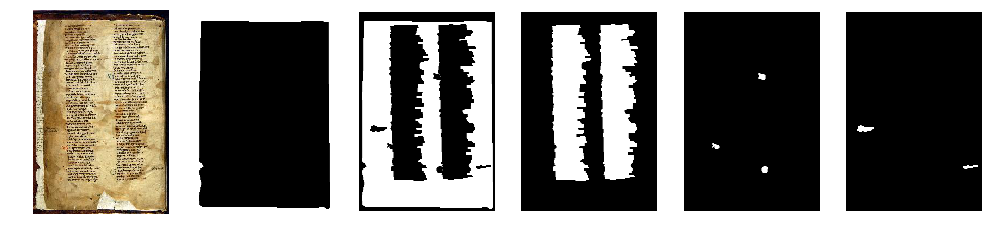

In [8]:
# Source
idx = 0
src = np.asarray(Image.open(train_files[0][idx]))
fig, ax = plt.subplots(1, 6, figsize=(20,5))
ax[0].imshow(src)
for c in range(5):
    ax[c+1].imshow(train_labels[idx,:,:,c], 'gray')
for axx in ax: axx.set_axis_off()

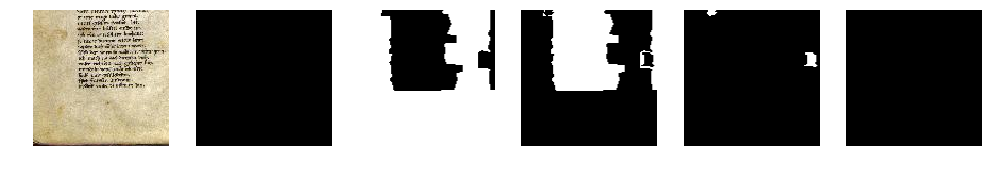

In [9]:
# Crop
t = next(data_gen(8, train_imgs, train_labels, crop=128, shuffle=False))
src = undo_pp(t[0][0]).astype(np.uint8)
fig, ax = plt.subplots(1, 6, figsize=(17,5))
ax[0].imshow(src)
for c in range(5):
    ax[c+1].imshow(t[1][0,:,:,c], 'gray')
for axx in ax: axx.set_axis_off()

# Model

In [10]:
input_shape = 128

In [11]:
from keras.layers import Input, Dropout, BatchNormalization, Concatenate, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

def conv_layer(x, f, k=3, s=1, p='same', act='relu', bn=False, transpose=False):
    k_init = 'he_uniform' if act == 'relu' else 'glorot_uniform'
    out = Conv2D(f, k, strides=s, padding=p, use_bias=False, kernel_initializer=k_init)(x)
    if bn: out = BatchNormalization()(out)
    if act is not None: out = Activation(act)(out)

    return out

def build_model():
    # x_in = Input((input_shape,input_shape,3))
    x_in = Input((None,None,3))
    
    # Encoder
    enc1 = conv_layer(x_in, 64)
    enc1 = conv_layer(enc1, 64)
    pool1 = MaxPool2D()(enc1)
    
    enc2 = conv_layer(pool1, 128)
    enc2 = conv_layer(enc2, 128)
    pool2 = MaxPool2D()(enc2)
        
    enc3 = conv_layer(pool2, 256)
    enc3 = conv_layer(enc3, 256)
    pool3 = MaxPool2D()(enc3)
        
    enc4 = conv_layer(pool3, 512)
    enc4 = conv_layer(enc4, 512)
    drop4 = Dropout(0.5)(enc4)

    
    # Decoder
    dec1 = conv_layer(UpSampling2D()(drop4), 256)
    dec1 = Concatenate()([enc3, dec1])
    dec1 = conv_layer(dec1, 256)
    
    dec2 = conv_layer(UpSampling2D()(dec1), 128)
    dec2 = Concatenate()([enc2, dec2])
    dec2 = conv_layer(dec2, 128)
    
    dec3 = conv_layer(UpSampling2D()(dec2), 128)
    dec3 = Concatenate()([enc1, dec3])
    dec3 = conv_layer(dec3, 128)
    
    # Out
    out = conv_layer(dec3, 64)
    out = conv_layer(out, 5, 1, act='sigmoid')
    
    model = Model(x_in, out)
    return model

Using TensorFlow backend.


In [12]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1728        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36864       activation_1[0][0]               
__________________________________________________________________________________________________
activation

# Train

In [13]:
lr = 1e-4
bs = 8
nb = math.ceil(len(train_imgs) / bs)

In [14]:
train_gen = data_gen(bs, train_imgs, train_labels, input_shape)
val_gen = data_gen(bs, val_imgs, val_labels, input_shape)
model.compile(Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
h = model.fit_generator(train_gen, 50, epochs=10, validation_data=val_gen, validation_steps=10)

Epoch 1/10
50/50 [==============================] - 7s 133ms/step - loss: 0.2451 - acc: 0.8891 - val_loss: 0.1406 - val_acc: 0.9362
Epoch 2/10
50/50 [==============================] - 4s 85ms/step - loss: 0.1726 - acc: 0.9227 - val_loss: 0.1267 - val_acc: 0.9450
Epoch 3/10
50/50 [==============================] - 4s 85ms/step - loss: 0.1542 - acc: 0.9304 - val_loss: 0.1194 - val_acc: 0.9467
Epoch 4/10
50/50 [==============================] - 4s 85ms/step - loss: 0.1475 - acc: 0.9328 - val_loss: 0.0961 - val_acc: 0.9582
Epoch 5/10
50/50 [==============================] - 4s 86ms/step - loss: 0.1417 - acc: 0.9364 - val_loss: 0.0923 - val_acc: 0.9623
Epoch 6/10
50/50 [==============================] - 4s 86ms/step - loss: 0.1354 - acc: 0.9384 - val_loss: 0.0922 - val_acc: 0.9597
Epoch 7/10
50/50 [==============================] - 4s 86ms/step - loss: 0.1298 - acc: 0.9414 - val_loss: 0.0916 - val_acc: 0.9591
Epoch 8/10
50/50 [==============================] - 4s 86ms/step - loss: 0.1310 - 

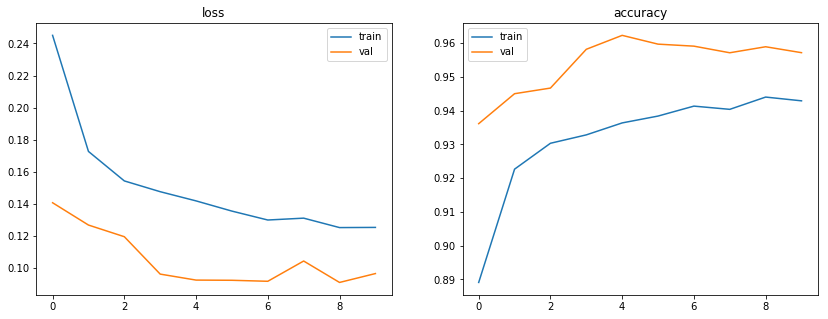

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(14,5))
ax[0].plot(h.history['loss'], label='train')
ax[0].plot(h.history['val_loss'], label='val')
ax[0].set_title('loss')
ax[1].plot(h.history['acc'], label='train')
ax[1].plot(h.history['val_acc'], label='val')
ax[1].set_title('accuracy')
for a in ax: a.legend()
plt.show()

In [17]:
model.evaluate(test_imgs, test_labels, bs)

13/13 [==============================] - 2s 124ms/step


[0.28809234041434068, 0.90066072574028599]

# Results on test

In [18]:
idx = np.random.choice(len(test_imgs))
idx

9

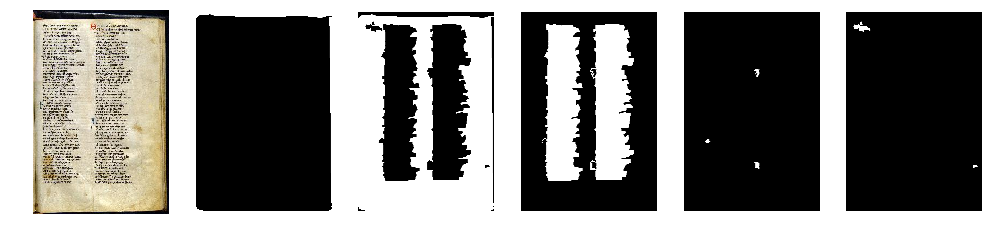

In [19]:
# True
src = np.asarray(Image.open(test_files[0][idx]))
fig, ax = plt.subplots(1, 6, figsize=(17,5))
ax[0].imshow(src)
for c in range(5):
    ax[c+1].imshow(test_labels[idx,:,:,c], 'gray')
for axx in ax: axx.set_axis_off()

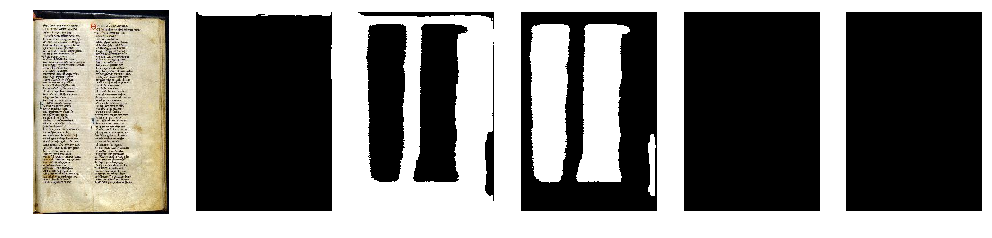

In [20]:
# Model
src = np.asarray(Image.open(test_files[0][idx]))
res = model.predict(test_imgs[idx][None])[0]
fig, ax = plt.subplots(1, 6, figsize=(17,5))
ax[0].imshow(src)
for c in range(5):
    ax[c+1].imshow(res[:,:,c] > .5, 'gray')
for axx in ax: axx.set_axis_off()